# Project 3 -- Distributed Storage Systems

## Instructions

Please read carefully:

* Solve the project yourself. No teamwork.
* If you have questions, please post these in the public channel on Slack. The answers may be relevant to others as well. 
* Feel free to import and use any additional Python package you need.
* You are allowed to solve the project using a different programming language. In this case, please send me your full code and instructions how to run it.
* Your code may be tested on similar but not exactly the same inputs.
* Make sure to fill in your `student_name` in the following block below.

In [5]:
student_name = 'David Mihola' # fill with your student name
assert student_name != 'your_student_name', 'Please fill in your student_name before you start.'

## Setup

In a distributed storage system that utilizes consistent hashing, the keys are assigned to nodes as follows. Identifiers are ordered on an identifier circle modulo $2^m$. Key $k$ is assigned to the first node whose identifier is equal to or follows (the identifier of ) $k$ in the identifier space. This node is called the successor node of key $k$. If identifiers are represented as a circle of numbers from $0$ to $2^m − 1$, then `successor(k)` is the first node clockwise from $k$. The identifier circle is also called the Chord ring.

The Chord protocol supports just one operation: given a key, it maps the key onto a node. Depending on the application using Chord, that node might be responsible for storing a value associated with the key. Chord uses consistent hashing to assign keys to Chord nodes. Consistent hashing tends to balance load, since each node receives roughly the same number of keys, and requires relatively little movement of keys when nodes join and leave the system. Please refer to the lecture materials and the paper [Chord: A P2P Lookup Protocol for Internet Applications](https://pdos.csail.mit.edu/papers/ton:chord/paper-ton.pdf) for further details.

Necessary imports:

In [6]:
import hashlib
import matplotlib.pyplot as plt
from typing import Union
from bisect import bisect, bisect_left, bisect_right

We will consider $m$=`total_slots`=$2^5$. The function below is used to map the key or the host information of a node to a value on the Chord ring.

In [7]:
def hash_fn(key: str):
    # hash_fn creates an integer equivalent of a SHA256 hash and
    # takes a modulo with the total number of slots in hash space.

    hsh = hashlib.sha256()
    # converting data into bytes and passing it to hash function
    hsh.update(bytes(key.encode('utf-8')))
    # converting the HEX digest into equivalent integer value
    return int(hsh.hexdigest(), 16) % pow(2,5)

Below we define several nodes used to store files on a Chord ring. We print hash values of each node.

In [8]:
class StorageNode:
    def __init__(self, name=None, host=None):
        self.name = name
        self.host = host
        
# storage_nodes holding instances of actual storage node objects
storage_nodes = [
    StorageNode(name='A', host='239.67.52.72'),
    StorageNode(name='B', host='137.70.131.229'),
    StorageNode(name='C', host='98.5.87.182'),
    StorageNode(name='D', host='11.225.158.95'),
    StorageNode(name='E', host='203.187.116.210'),
    StorageNode(name='F', host='107.117.238.203'),
    StorageNode(name='G', host='27.161.219.131'),
]

for node in storage_nodes:
    print(f"node {node.name} has hash {hash_fn(node.host)}")

node A has hash 21
node B has hash 16
node C has hash 18
node D has hash 28
node E has hash 4
node F has hash 29
node G has hash 25


We generate movie files and hash them using the same hash function above. The example below generates 15 files.

In [9]:
# Create a list of movie files to be stores on the nodes
numfiles = 15
filelist = ['f%d.mov' % x for x in range(0,numfiles)]

for file in filelist:
    print(f"file {file} has hash {hash_fn(file)}")

file f0.mov has hash 15
file f1.mov has hash 7
file f2.mov has hash 6
file f3.mov has hash 5
file f4.mov has hash 17
file f5.mov has hash 30
file f6.mov has hash 18
file f7.mov has hash 22
file f8.mov has hash 24
file f9.mov has hash 12
file f10.mov has hash 27
file f11.mov has hash 7
file f12.mov has hash 10
file f13.mov has hash 12
file f14.mov has hash 5


## 1 - Visualize Consistent Hashing [5 points]

**Your task:** Given the list of files and nodes above, visualize the Chord ring with keys and nodes mapped.

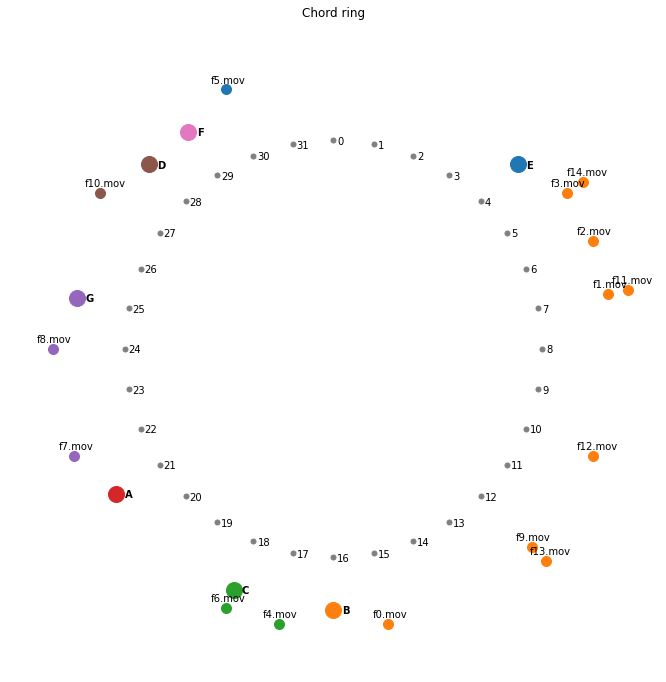

In [142]:
import numpy as np 
import matplotlib.pyplot as plt 

cmap_table = plt.get_cmap("tab10")

num_nodes = len(storage_nodes)
nodes = [[hash_fn(node.host), node.name] for node in storage_nodes]
nodes.sort()
files = [[hash_fn(file), file] for file in filelist]

num_plots = 1 << 5
angles = np.linspace(-np.pi / 2, 1.5 * np.pi, num_plots + 1) * -1 # -1 to rotate clockwise

node_angles = angles[[hash for hash, _ in nodes]]
file_angles = angles[[hash for hash, _ in files]]
for i, file_angle in enumerate(file_angles):
    files[i].append(file_angle)

file_angles_dictonaries = []
for file in files:
    i = 0
    while True:
        if len(file_angles_dictonaries) == i:
            file_angles_dictonaries.append({file[0]: file})
            break
        elif not file_angles_dictonaries[i].get(file[0], False):
            file_angles_dictonaries[i][file[0]] = file
            break
        else:
            i += 1

file_lists = [sorted(list(file_angles_dict.values())) for file_angles_dict in file_angles_dictonaries]

figure, axis = plt.subplots(1, figsize=(12, 12), facecolor="white")
axis.set_aspect(1)

radius = 8
angles = angles[:num_plots]
x = radius * np.cos(angles)
y = radius * np.sin(angles)
axis.scatter(x, y, s=25, c="gray")
for i, (xi, yi) in enumerate(zip(x, y)):
    axis.annotate(i, (xi + 0.15, yi - 0.15))

radius = 10
x = radius * np.cos(node_angles)
y = radius * np.sin(node_angles)
for i, (xi, yi) in enumerate(zip(x, y)):
    axis.plot(xi, yi, marker="o", markersize=16, markerfacecolor=cmap_table(i), markeredgecolor=cmap_table(i))
for i, (node, xi, yi) in enumerate(zip(nodes, x, y)):
    axis.annotate(node[1], (xi + 0.32, yi - 0.15), fontweight="bold")

nodes.insert(0, [nodes[-1][0] - num_plots, ""])
nodes.pop()
for files in file_lists:
    radius += 0.75
    file_angles = [file[2] for file in files]
    x = radius * np.cos(file_angles)
    y = radius * np.sin(file_angles)
    for i, ((file_hash, *_), xi, yi) in enumerate(zip(files, x, y)):
        for j, (node_hash, _) in enumerate(nodes):
            if file_hash > node_hash and file_hash <= nodes[(j + 1) % num_nodes][0]:
                break
            color = cmap_table((j + 1) % num_nodes)
        axis.plot(xi, yi, marker="o", markersize=10, markerfacecolor=color, markeredgecolor=color)
    for i, (file, xi, yi) in enumerate(zip(files, x, y)):
        axis.annotate(file[1], (xi - 0.6, yi + 0.25))

axis.set_xlim((-radius - 1, radius + 1))
axis.set_ylim((-radius - 1, radius + 1))
axis.set_frame_on(False)
axis.set_xticks([], [])
axis.set_yticks([], [])

plt.title("Chord ring")
plt.savefig("chord_ring")
plt.show()

## 2 - Compute Finger tables in Chord [5 points]

Each Chord node needs “routing” information about only a few other nodes. Because the routing table is distributed, a Chord node communicates with other nodes in order to perform a lookup. In the steady state, in an N-node system, each node maintains information about only O(log N ) other nodes, and resolves all lookups via O(log N ) messages to other nodes. 

**Your task:** Compute a finger table for each node on the Chord ring. The function `compute_finger_tables()` returns a dictionary `{node.name : [finger table entries]}`.

In [144]:
def compute_finger_tables(nodes):
    M = 5
    nodes_hashed = [(hash_fn(node.host), node.name) for node in nodes]
    nodes_hashed.sort()
    supper_table = []
    idx = 0
    for node_hash, node_name in nodes_hashed:
        while idx < node_hash:
            supper_table.append(node_name)
            idx += 1
    
    max_nodes = 1 << M
    while len(supper_table) < max_nodes:
        supper_table.append(nodes_hashed[0][1])

    finger_tables = {}
    for node_hash, node_name in nodes_hashed:
        finger_table = []
        for i in range(M):
            offset = 1 << i
            finger_table.append(supper_table[(node_hash + offset) % max_nodes])
        finger_tables[node_name] = finger_table

    return finger_tables

ftabs = compute_finger_tables(storage_nodes)
print(ftabs)
print(ftabs[storage_nodes[0].name])

{'E': ['B', 'B', 'B', 'B', 'A'], 'B': ['C', 'A', 'A', 'G', 'E'], 'C': ['A', 'A', 'G', 'D', 'E'], 'A': ['G', 'G', 'D', 'E', 'B'], 'G': ['D', 'D', 'E', 'E', 'B'], 'D': ['E', 'E', 'E', 'B', 'B'], 'F': ['E', 'E', 'E', 'B', 'B']}
['G', 'G', 'D', 'E', 'B']


## 3 - Find a key [5 points]

**Your task:** Provided an initial node and a key on the ring, print the nodes on the route from the initial node to the node that stores the key. Include the initial node and the destination node in the routing path. Use the finger tables computed above.

In [ ]:
def route_to_key(init_node : str, key : int):
    node_list = []
    ### START CODE HERE ###
    None
    ### END CODE HERE ###
    return node_list

print(route_to_key(storage_nodes[0].name, filelist[0]))

## 4 - Equal load on every node [5 points]

**Your task:** Generate 1000 key to store in the constructred system (similar to above) and measure the empirical load on every node (=show a bar plot). To improve the load distribution on all nodes, introduce additional hash functions (see [hashlib](https://docs.python.org/3/library/hashlib.html)) and hash the same node to multiple locations on the ring (also see the lecture). Re-run the test and plot the change to the distribution (show the result for using 1, 2 and 3 hash functions).

In [ ]:
### START CODE HERE ###
None 
### END CODE HERE ###

## 5 - How to Submit Your Solution?

Download your notebook (File --> Download --> Download .ipynb) and send per email to [saukh@tugraz.at](mailto:saukh@tugraz.at).